Plots: Calculating and coloring based on median absolute deviation (MAD) of the median light curves (code taken from ```hdf5_C8_channel_summary_1med.py``)

In [1]:
from analysis import *

import h5py
import K2fov
from astropy.convolution import convolve, Box1DKernel
from astropy.stats import median_absolute_deviation

from matplotlib import colors
from matplotlib import patheffects

import richardsplot

In [2]:
campaign = 8
cadences = 3853# there are 3853 cadence points in c8

#campaign = 16
#cadences = 3894# there are 3894 cadence points in c16

time = np.arange(cadences)/48.0
    
fov = K2fov.getKeplerFov(campaign)
channels = np.arange(1,85)
good_channels = channels[~np.isin(channels, fov.brokenChannels)]

In [3]:
%%time
#channel = 55

mads8 = []
mads_smooth8= []

for channel in channels:
    
    mod,submod = get_submod(channel)
    submod-=1 # submods are 0-3 in the hdf5 file

    hdf5_file = "/Users/rachelbuttry/K2/K2C%s_target_pixels.hdf5"%campaign
    #hdf5_file = "/home/rachel/Research/K2/K2C%s_target_pixels.hdf5"%campaign
    # there are 23117 objects in the campaign 8 hdf5 file
    

    try:
        with h5py.File(hdf5_file, 'r') as f:
            channel_epics = np.array(list(f['%s/%s/%s'%(campaign, mod,submod)].keys()))# look at objects in given channel).astype(int)

    except:
        mads8.append(np.nan)
        mads_smooth8.append(np.nan)
        continue
    # need the kepler magnitudes
    all_targets = pd.read_csv("./K2_official_targets/K2Campaign%stargets.csv"%campaign, skipinitialspace=True)

    # saving lcs to take the median
    arr = []

    with h5py.File(hdf5_file, 'r') as f:
        channel_epics = np.array(list(f['%s/%s/%s'%(campaign, mod, submod)].keys()))# look at objects in given channel).astype(int)

        rel_epics = channel_epics[np.isin(channel_epics, all_targets['EPIC ID'][np.logical_and(all_targets['magnitude'] > 13, all_targets['magnitude'] < 20)])]
        #print(len(rel_epics))

        # loop thru the objects
        for epic in rel_epics:
            d = np.array(f['%s/%s/%s/%s'%(campaign, mod, submod, epic)]['data'])
            lc_hdf5 = np.nansum(np.nansum(d, axis=1), axis=1)

            # handle spurious cadences
            lc = lk.LightCurve(time, flux=lc_hdf5)
            _, spurious_cad = lc.flatten().remove_outliers(return_mask=True) # remove spurious cadences
            lc_raw = lc.flux

            # interpolate
            cadno = np.arange(len(lc_raw)) # get an array to serve as our time/cadence measurement
            interped_vals = np.interp(cadno[spurious_cad], cadno[~spurious_cad], lc_raw[~spurious_cad])
            # replace spurious cadence values with the interpolated values
            lc_raw[spurious_cad] = interped_vals

            lc_raw -= np.mean(lc_raw)
            lc_raw = lc_raw/np.max(np.abs(lc_raw))
            arr.append(lc_raw)

    flux = np.nanmedian(np.atleast_2d(np.array(arr)), axis=0)
    # subtract linear trend
    m,b = np.polyfit(np.arange(len(flux)), flux, 1)

    # subtracting it
    flux -=  (m*np.arange(len(flux)))    
    
    MAD = median_absolute_deviation(flux)
    mads8.append(MAD)
    
    flux_smooth = convolve(flux, Box1DKernel(250), boundary='extend')
    MAD_smooth = median_absolute_deviation(flux_smooth)
    mads_smooth8.append(MAD_smooth)

CPU times: user 14min 23s, sys: 35.8 s, total: 14min 59s
Wall time: 3min 56s


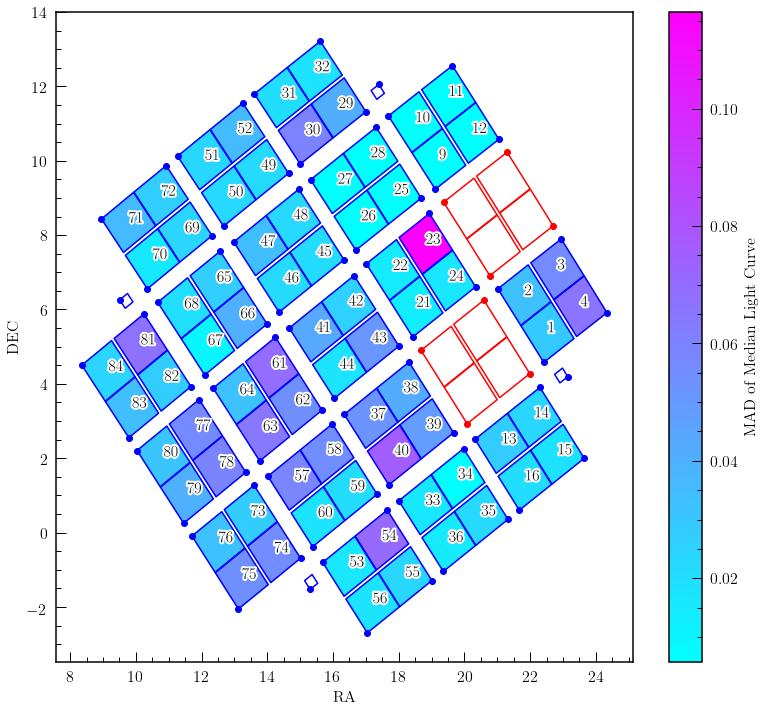

In [4]:
metric_arr = mads_smooth8.copy()

cmap = plt.cm.cool
norm = colors.Normalize(vmin=np.nanmin(metric_arr), vmax=np.nanmax(metric_arr))

# plotting 
fig = plt.figure(figsize=(11,10))

fov.plotPointing(K2fov.projection.PlateCaree()) # maptype so we get ra/decs 
for ch, mad in zip(good_channels, metric_arr):
    x = fov.getChannelAsPolygon(ch, maptype=K2fov.projection.PlateCaree()).polygon # get corners of channel 
    plt.fill(x[:,0], x[:,1], color=cmap(norm(mad))) # fill with normalized color
    
    # put the label in the rough center of the channel
    txt = plt.text(np.mean(x[:,0]), np.mean(x[:,1]), int(ch), fontsize=16)
    txt.set_path_effects([patheffects.withStroke(linewidth=4, foreground='w')])

sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm)
cbar.ax.set_ylabel("MAD of Median Light Curve",  fontsize=16)

plt.xlabel('RA', fontsize=16)
plt.ylabel('DEC', fontsize=16)

#plt.title("K2 Campaign %s MAD of Median Light Curve per Channel"%campaign, fontsize=16)
plt.tight_layout()

#plt.savefig("submit/FOV_C%s_MAD.pdf"%campaign)

/Users/rachelbuttry/anaconda3/lib/python3.6/site-packages/numpy/lib/histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/rachelbuttry/anaconda3/lib/python3.6/site-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


(array([ 2.,  8., 15., 10.,  8.,  6.,  6.,  2.,  6.,  5.,  2.,  3.,  1.,
         0.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([0.00563838, 0.01118348, 0.01672858, 0.02227368, 0.02781878,
        0.03336389, 0.03890899, 0.04445409, 0.04999919, 0.05554429,
        0.0610894 , 0.0666345 , 0.0721796 , 0.0777247 , 0.0832698 ,
        0.08881491, 0.09436001, 0.09990511, 0.10545021, 0.11099532,
        0.11654042]),
 <a list of 20 Patch objects>)

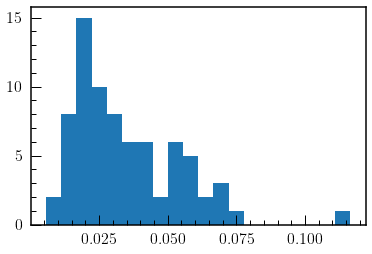

In [5]:
plt.hist(mads_smooth8, bins=20)

---

In [6]:
campaign = 16
cadences = 3894# there are 3894 cadence points in c16

time = np.arange(cadences)/48.0
    
fov = K2fov.getKeplerFov(campaign)
channels = np.arange(1,85)
good_channels = channels[~np.isin(channels, fov.brokenChannels)]

In [12]:
%%time
#channel = 55

mads16 = []
mads_smooth16 = []

for channel in channels:
    
    mod,submod = get_submod(channel)
    submod-=1 # submods are 0-3 in the hdf5 file

    hdf5_file = "/Users/rachelbuttry/K2/K2C%s_target_pixels.hdf5"%campaign
    #hdf5_file = "/home/rachel/Research/K2/K2C%s_target_pixels.hdf5"%campaign
    # there are 23117 objects in the campaign 8 hdf5 file
    

    try:
        with h5py.File(hdf5_file, 'r') as f:
            channel_epics = np.array(list(f['%s/%s/%s'%(campaign, mod,submod)].keys()))# look at objects in given channel).astype(int)

    except:
        mads16.append(np.nan)
        mads_smooth16.append(np.nan)
        continue
    # need the kepler magnitudes
    all_targets = pd.read_csv("./K2_official_targets/K2Campaign%stargets.csv"%campaign, skipinitialspace=True)

    # saving lcs to take the median
    arr = []

    with h5py.File(hdf5_file, 'r') as f:
        channel_epics = np.array(list(f['%s/%s/%s'%(campaign, mod, submod)].keys()))# look at objects in given channel).astype(int)

        rel_epics = channel_epics[np.isin(channel_epics, all_targets['EPIC ID'][np.logical_and(all_targets['magnitude'] > 13, all_targets['magnitude'] < 20)])]
        #print(len(rel_epics))

        # loop thru the objects
        for epic in rel_epics:
            d = np.array(f['%s/%s/%s/%s'%(campaign, mod, submod, epic)]['data'])
            lc_hdf5 = np.nansum(np.nansum(d, axis=1), axis=1)

            # handle spurious cadences
            lc = lk.LightCurve(time, flux=lc_hdf5)
            _, spurious_cad = lc.flatten().remove_outliers(return_mask=True) # remove spurious cadences
            lc_raw = lc.flux

            # interpolate
            cadno = np.arange(len(lc_raw)) # get an array to serve as our time/cadence measurement
            interped_vals = np.interp(cadno[spurious_cad], cadno[~spurious_cad], lc_raw[~spurious_cad])
            # replace spurious cadence values with the interpolated values
            lc_raw[spurious_cad] = interped_vals

            lc_raw -= np.mean(lc_raw)
            lc_raw = lc_raw/np.max(np.abs(lc_raw))
            arr.append(lc_raw)

    flux = np.nanmedian(np.atleast_2d(np.array(arr)), axis=0)
    # subtract linear trend
    m,b = np.polyfit(np.arange(len(flux)), flux, 1)

    # subtracting it
    flux -=  (m*np.arange(len(flux)))    
    
    MAD = median_absolute_deviation(flux)
    mads16.append(MAD)
    
    flux_smooth = convolve(flux, Box1DKernel(250), boundary='extend')
    MAD_smooth = median_absolute_deviation(flux_smooth)
    mads_smooth16.append(MAD_smooth)

CPU times: user 19min 7s, sys: 54.4 s, total: 20min 1s
Wall time: 5min 18s


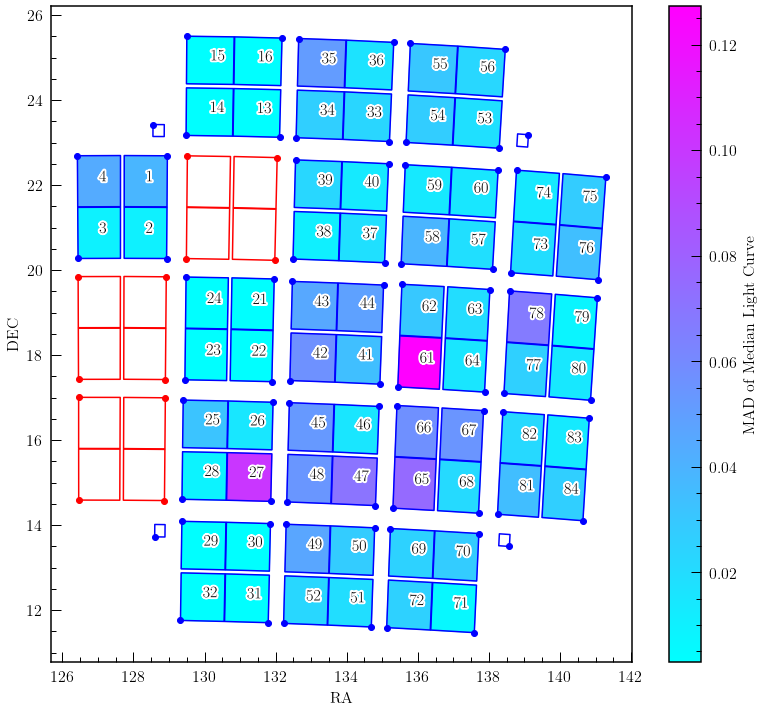

In [13]:
metric_arr = mads_smooth16.copy()

cmap = plt.cm.cool
norm = colors.Normalize(vmin=np.nanmin(metric_arr), vmax=np.nanmax(metric_arr))

# plotting 
fig = plt.figure(figsize=(11,10))

fov.plotPointing(K2fov.projection.PlateCaree()) # maptype so we get ra/decs 
for ch, mad in zip(good_channels, metric_arr):
    x = fov.getChannelAsPolygon(ch, maptype=K2fov.projection.PlateCaree()).polygon # get corners of channel 
    plt.fill(x[:,0], x[:,1], color=cmap(norm(mad))) # fill with normalized color
    
    # put the label in the rough center of the channel
    txt = plt.text(np.mean(x[:,0]), np.mean(x[:,1]), int(ch), fontsize=16)
    txt.set_path_effects([patheffects.withStroke(linewidth=4, foreground='w')])

sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm)
cbar.ax.set_ylabel("MAD of Median Light Curve",  fontsize=16)

plt.xlabel('RA', fontsize=16)
plt.ylabel('DEC', fontsize=16)

#plt.title("K2 Campaign %s MAD of Median Light Curve per Channel"%campaign, fontsize=16)
plt.tight_layout()

#plt.savefig("submit/FOV_C%s_MAD.pdf"%campaign)

/Users/rachelbuttry/anaconda3/lib/python3.6/site-packages/numpy/lib/histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/rachelbuttry/anaconda3/lib/python3.6/site-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


(array([ 6., 13., 11., 11.,  6.,  6.,  6.,  3.,  5.,  0.,  2.,  1.,  0.,
         0.,  0.,  1.,  0.,  0.,  0.,  1.]),
 array([0.00290892, 0.00912569, 0.01534245, 0.02155922, 0.02777599,
        0.03399276, 0.04020953, 0.0464263 , 0.05264307, 0.05885984,
        0.0650766 , 0.07129337, 0.07751014, 0.08372691, 0.08994368,
        0.09616045, 0.10237722, 0.10859399, 0.11481076, 0.12102752,
        0.12724429]),
 <a list of 20 Patch objects>)

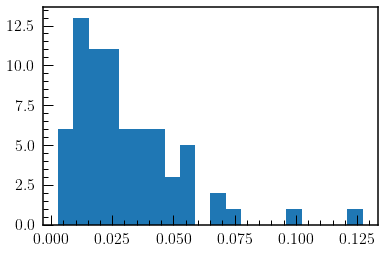

In [14]:
plt.hist(mads_smooth16, bins=20)

In [18]:
# save the median array to be loaded into the other notebook
save_mads = np.median(np.array([mads_smooth8, mads_smooth16]), axis=0)

np.save('./MADS_C8_C16_median.npy', save_mads)